## Imports

In [19]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('Libraries')
import signal_processing as spl 
spl = reload(spl)

## File of Raw Recording (.m4a, .wav, whatever) and text input

In [108]:
raw_file = 'audio/perfect_dataset.wav'
name = 'perfect_dataset'
raw_text_file = 'text/perfect.txt'
text = open(raw_text_file, 'r').read()
print len(text)
true_results = pd.read_csv('data/perfect_out.csv')#, index_col=0)
true_results = true_results[true_results['letter'] != 'none'].reset_index()
true_results.head()

3453


,index,Unnamed: 0,letter,ind,time
0,0,0,a,0,1.872109
1,1,1,l,1,2.237761
2,2,2,i,2,2.592897
3,3,3,c,3,2.877419
4,4,4,e,4,3.110680


In [109]:
# raw_file = 'alice_space_slow.wav.m4a'
# name = 'alice_space_slow'
# raw_text_file = 'alice_space_slow.txt'
# text = open(raw_text_file, 'r').read()
# print len(text)

## Parameters

In [110]:
MAX_THRESH = 900.
MIN_THRESH = 3.
MIN_DIST = 29
KEY_LEN = 350



VERBOSE = True
MIN_FREQ = 400
MAX_FREQ = 12000

BACK_PROP = .1
MINT = 0.0
MAXT = None
FIGSZ = (16,8)

In [111]:
BAD_INDS = []
TO_ADD = []

## Get raw signal

.wav file location: audio/perfect_dataset.wav
rate: 44100 measurements per second
length of audio: 1211.24569161 seconds
rate * length =  53415936 measurements


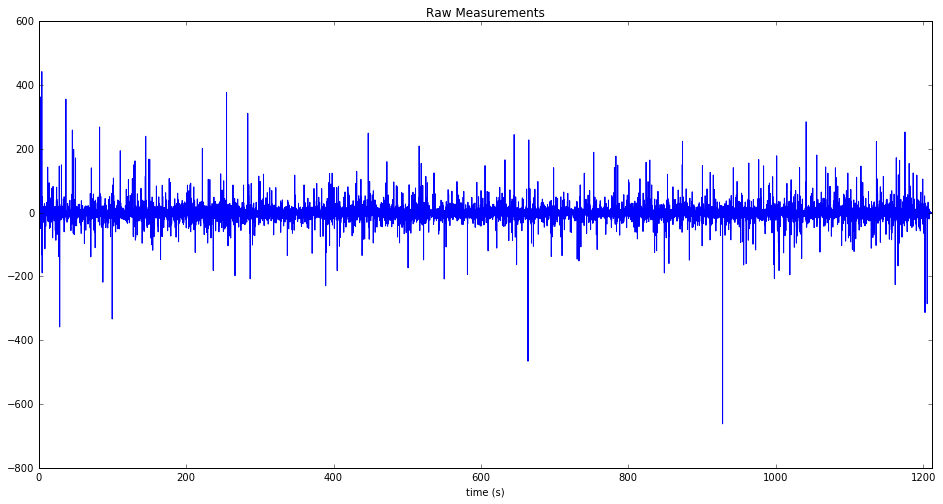

In [112]:
signal_df, rate, wav_file = spl.open_audio(raw_file, verbose = VERBOSE, head = 5, 
                                           plt_every = 2**8, figsz = FIGSZ)
    
if not MAXT:
    MAXT = signal_df.index[-1]

## Compute the windowed discrete-time Fourier transform of a signal using a sliding window

freqs.shape (129,) min: 0.0 max 22050.0
[   0.        172.265625  344.53125   516.796875  689.0625  ]

fourier_df:


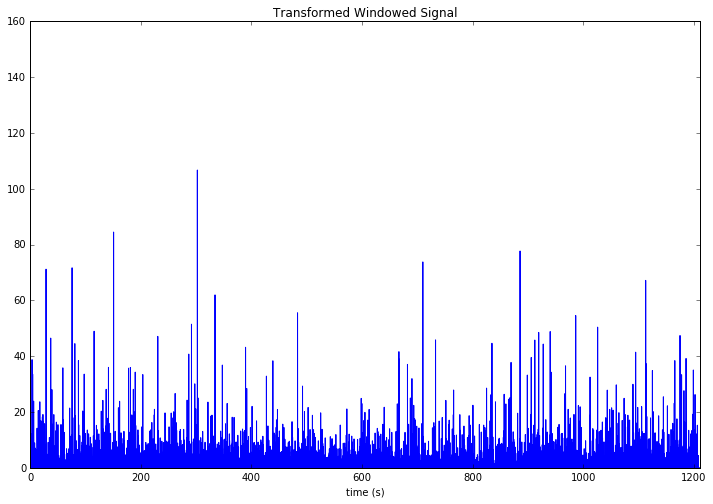

In [113]:
freqs, fourier_df = spl.get_windowed_fourier(signal_df, rate, MIN_FREQ = MIN_FREQ, 
                                             MAX_FREQ = MAX_FREQ, verbose = VERBOSE, head = 5)

## Detect Peaks

Number of Keys detected: 1675


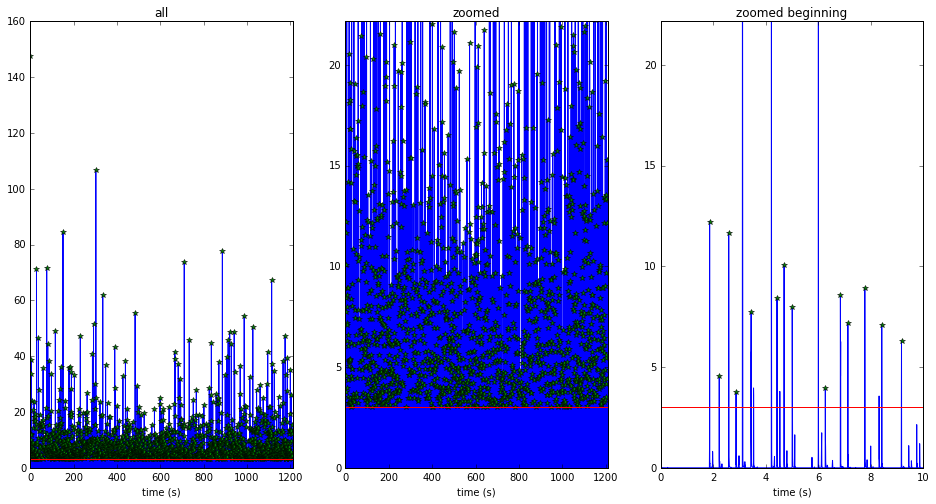

In [114]:
spl = reload(spl)
sfourier_df, ssignal_df, all_peaks = spl.detect_peaks(fourier_df, signal_df, 
                                                      t0 = MINT, t1 = MAXT , min_thresh = MIN_THRESH,
                                                      max_thresh = MAX_THRESH, MIN_DIST = MIN_DIST, 
                                                      KEY_LEN = KEY_LEN, back_prop = BACK_PROP, 
                                                      figsz = FIGSZ, to_add = TO_ADD)

In [115]:
true_peaks= true_results[['letter', ' time']].copy()
true_peaks['peak time'] = true_peaks[' time']
true_peaks['char'] = true_peaks['letter']
true_peaks = true_peaks.drop(['letter', ' time'],axis=1)
key_len_in_sec = KEY_LEN / 1000.
true_peaks['start time'] = true_peaks['peak time'] - BACK_PROP * key_len_in_sec
true_peaks['end time'] = true_peaks['peak time'] + (1 - BACK_PROP) * key_len_in_sec
true_peaks['signal'] = true_peaks['peak time'].map(lambda t: sfourier_df.ix[sfourier_df.iloc[np.abs(sfourier_df.index-t).argsort()[0]].name]['signal'])
true_peaks.tail()

,peak time,char,start time,end time,signal
3448,1206.603440,a,1206.568440,1206.918440,0.000357
3449,1206.880633,g,1206.845633,1207.195633,0.000357
3450,1207.134864,a,1207.099864,1207.449864,0.000357
3451,1207.493027,i,1207.458027,1207.808027,0.000357
3452,1207.817996,n,1207.782996,1208.132996,0.000357


In [116]:
if all_peaks.shape[0] > len(list(text)):
    all_peaks['char'] = ''
    all_peaks['char'].iloc[:len(list(text))] = list(text)
else:
    all_peaks['char'] = list(text[:all_peaks.shape[0]])
all_peaks.tail()

,peak time,signal,start time,end time,char
1670,1202.852426,5.603288,1202.817426,1203.167426,a
1671,1203.573696,9.687776,1203.538696,1203.888696,t
1672,1205.417506,12.132555,1205.382506,1205.732506,
1673,1206.575601,15.263569,1206.540601,1206.890601,t
1674,1208.515918,4.405808,1208.480918,1208.830918,h


In [119]:
def build_input(pks_df):
    starts=  pks_df['start time'].to_dict()
    ends = pks_df['end time'].to_dict()
    lent= len(signal_df.ix[(signal_df.index >= starts[0]) & (signal_df.index <= ends[0]), 'signal'].values) - 1
    
    helper = lambda x : signal_df.ix[(signal_df.index >= starts[x]) & (signal_df.index <= ends[x]), 'signal'][:lent]
    inputs = map(helper, range(pks_df.shape[0]))
    CHARACTER_INPUTS = pd.concat([pks_df, pd.DataFrame(map(lambda x : x.reset_index(drop=True), inputs)).reset_index(drop=True)], axis = 1)
    return CHARACTER_INPUTS
ML_INPUT = build_input(true_peaks)
ML_INPUT.head()

,peak time,char,start time,end time,signal,0,1,2,3,4,...,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434
0,1.872109,a,1.837109,2.187109,12.221592,-0.087619,-0.090486,0.006988,0.071424,-0.000958,...,0.120396,0.249677,0.192247,0.187148,0.175489,0.171375,0.162599,0.100234,-0.036829,-0.093871
1,2.237761,l,2.202761,2.552761,4.559612,0.285981,0.086185,-0.078204,0.012745,-0.202153,...,0.214179,0.330011,0.218272,0.261467,0.319067,0.168638,0.001347,0.000828,0.063317,0.144865
2,2.592897,i,2.557897,2.907897,0.046671,0.067080,0.208308,0.172324,0.112580,0.103748,...,-0.478881,-0.890660,-2.981151,-1.779704,-2.004638,-2.495325,0.962512,-1.168835,-2.618910,0.413596
3,2.877419,c,2.842419,3.192419,3.743446,-0.727105,-0.638962,-0.518911,-0.489755,-0.327397,...,-0.509076,1.625004,6.420588,5.670187,3.093728,2.872973,1.050325,2.511591,2.751873,0.625943
4,3.110680,e,3.075680,3.425680,0.000810,-0.157697,-0.164877,-0.172315,-0.180363,-0.141560,...,-0.035559,-0.063705,-0.200838,-0.370470,-0.344790,-0.326860,-0.405144,-0.516910,-0.637322,-0.530543


In [120]:
ML_INPUT.to_csv('data/%s.csv' % name)

In [ ]:

all_peaks = all_peaks.drop(BAD_INDS).reset_index()

all_peaks['char'] = all_peaks['char'].replace(' ', '#SPACE').fillna('')

all_peaks['is_space'] = (all_peaks['char'] == "#SPACE").astype(int)
all_peaks['peak_diff'] = all_peaks['end time'].diff().shift(-1)

space = all_peaks[all_peaks['is_space']==1]
th = .760
tofix = space[space['peak_diff'] < th]
good_until = tofix.index[0]
good = space[(space['peak_diff'] > th) & (space.index < good_until)]
tofix.head()

all_peaks.head(10)

In [ ]:
# tofix.tail()

In [ ]:
# s,e = 596, 596.15
# sfourier_df[(sfourier_df.index > s) & (sfourier_df.index < e)]['signal'].max()
# sfourier_df[(sfourier_df.index > s) & (sfourier_df.index < e)]['signal'].argmax()
# sfourier_df[(sfourier_df.index > s) & (sfourier_df.index < e)]['signal'].plot()


## Determine Windows in subset of audio

In [ ]:
sfourier_df, ssignal_df, peaks = spl.detect_peaks(fourier_df, signal_df, t0 = MINT, t1 = MAXT , 
                                                 min_thresh = MIN_THRESH, max_thresh = MAX_THRESH, 
                                                  MIN_DIST = MIN_DIST, KEY_LEN = KEY_LEN, back_prop = BACK_PROP, 
                                                  figsz = FIGSZ, to_add = TO_ADD)

In [ ]:
helper = all_peaks.copy().set_index('peak time')

## Build Videos of Clicks

In [ ]:
_FRAME_BREAK = 20.
# _FRAME_BREAK = 5.
MAX_FRAMES = _FRAME_BREAK * 2

SLOWDOWN = 1.5

### Fourier 

In [ ]:
# spl = reload(spl)
# outfile = spl.visualize_clicks(ssignal_df, sfourier_df, peaks, all_peaks, rate, max_thresh, min_thresh  = min_thresh, outfile = name + '_fourier_clicks.mp4', 
#                                MAX_FRAMES =MAX_FRAMES , _FRAME_BREAK = _FRAME_BREAK, SLOWDOWN = SLOWDOWN, figsz = (12,8))
# outfile
# spl.display_animation_from_file(outfile)

In [ ]:
spl = reload(spl)
outfile = spl.visualize_clicks(ssignal_df, sfourier_df, all_peaks, all_peaks, rate, max_thresh, min_thresh  = min_thresh, outfile = name + '_fourier_clicks.mp4', 
                               MAX_FRAMES =MAX_FRAMES , _FRAME_BREAK = _FRAME_BREAK, SLOWDOWN = SLOWDOWN, figsz = (12,8))
outfile
spl.display_animation_from_file(outfile)

### Raw Signal

In [ ]:
# spl = reload(spl)
# outfile = spl.visualize_clicks(ssignal_df, ssignal_df, peaks,all_peaks, rate, max_thresh, min_thresh  = min_thresh, outfile = name + '_signal_clicks.mp4', 
#                                MAX_FRAMES = MAX_FRAMES, _FRAME_BREAK = _FRAME_BREAK, SLOWDOWN = SLOWDOWN, figsz = (12,8))
# outfile
# spl.display_animation_from_file(outfile)

## Turn into input

In [ ]:
starts=  all_peaks['start time'].to_dict()
ends = all_peaks['end time'].to_dict()
lent= len(signal_df.ix[(signal_df.index >= starts[0]) & (signal_df.index <= ends[0]), 'signal'].values) - 1
inputs = map(lambda x : signal_df.ix[(signal_df.index >= starts[x]) & (signal_df.index <= ends[x]), 'signal'][:lent], range(all_peaks.shape[0]))
CHARACTER_INPUTS = pd.concat([all_peaks, pd.DataFrame(map(lambda x : x.reset_index(drop=True), inputs)).reset_index(drop=True)], axis = 1)
CHARACTER_INPUTS.head(10)

In [ ]:
# CHARACTER_INPUTS.shape

In [ ]:
CHARACTER_INPUTS.to_csv('LABELED_CHARACTER_INPUTS.csv')

In [ ]:
all_peaks.to_csv('allpeaks.csv')

In [ ]:
#to_add  = [23.18, 60.939999999999998, 82.432, 91.161333333333332, 103.374, 109.70666666666666, 126.69333333333333, 137.49199999999999,
#          153.172, 153.20466666666667, 176.66399999999999, 189.94533333333334, 198.05600000000001, 227.11066666666667,
#          254.91, 256.31, 256.58533333333332, 260.74799999999999, 267.03399999999999,400.68733333333336, 476.642,477.37466666666666, 488.59800000000001,
#          496.69, 498.83666666666664, 506., 522.76733333333334, 537.73800000000006, 541.10266666666666, 550.27733333333333,
#          559.89066666666668, 560.50199999999995, 571.39400000000001, 594.62933333333331,
#          596.10400000000004, 596.22066666666672]

# bad_inds = [80,130,135, 159,161, 183, 197, 230, 243, 270, 299, 311, 318, 342, 343, 345, 356, 380, 414, 424, 
#             553, 557, 627, 669, 685, 736, 759, 762,775,809, 820, 826, 942, 944, 978, 993, 995, 1025,1030, 1042, 1049,
#            1053, 1064, 1076]
